In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import os
import pathlib
import pandas as pd
import re
import numpy as np

%matplotlib inline
AUTOTUNE = tf.data.experimental.AUTOTUNE

import sys
sys.path.append('../utilities')
from utilities import Timer, gram_matrix

from tensorflow.keras.models             import Sequential, load_model, Sequential
from tensorflow.keras.layers             import Conv2D, MaxPool2D, Input, InputLayer, Dropout, Dense, Flatten
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers         import Adam
from tensorflow.keras.metrics            import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.losses             import CategoricalCrossentropy
from tensorflow.keras.callbacks          import CSVLogger, EarlyStopping, ModelCheckpoint, TerminateOnNaN
import tensorflow.keras.applications     as     applications
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Concatenate, Dropout
from tensorflow.keras.utils import plot_model

Warning: this code requires a bug fix in keras-applications 1.0.9. However, 1.0.9 has not been released. Workaround:
- pip install the current repo https://github.com/keras-team/keras-applications (1.15.20)

# Load data as a TensorFlow dataset

Largely based on the TensorFlow [tutorial](https://www.tensorflow.org/tutorials/load_data/images)

In [2]:
width = height = 224
batch_size = 128

In [3]:
# Load the classnames

df = pd.read_excel('../dataset/artist-breakdown-annotated.xlsx')
df = df[df.fillna(0).keep.astype(bool)]
class_names = df.artist.unique()
class_names.sort()

In [4]:
def load_dataset(data_subdir, 
                 shuffle = True, shuffle_buffer_size=1000,
                 batch_size = batch_size,
                 width      = width,
                 height     = height,
                 repeat     = True,
                 cache      = True
                ):
    # Load the list of file names in the form of data_dir/class_name/file_name.jpg
    data_dir = pathlib.Path('../dataset/images/') / pathlib.Path(data_subdir)
    list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

    dataset_size = len(list(list_ds))
    
    # Function to get the label
    def get_label(file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        return parts[-2] == class_names
    
    # Function to get the image
    def decode_img(file_path):
        # Load the image
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # Resize
        return tf.image.resize(img, [width, height])
    
    def preprocess_img(img, label):
        return applications.vgg19.preprocess_input(img), label
    
    # Combine both processes
    def process_path(file_path):
        return decode_img(file_path), get_label(file_path)
    
    # Create the dataset
    ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = ds.map(preprocess_img)
    
    if cache:
        ds = ds.cache()
    
    if shuffle:
        if shuffle_buffer_size is not None:
            ds = ds.shuffle(buffer_size = shuffle_buffer_size)
        else:
            ds = ds.shuffle(buffer_size = dataset_size)
            
    if repeat:
        ds = ds.repeat()
    
    ds = ds.batch(batch_size).prefetch(buffer_size = AUTOTUNE)    
    return ds, dataset_size

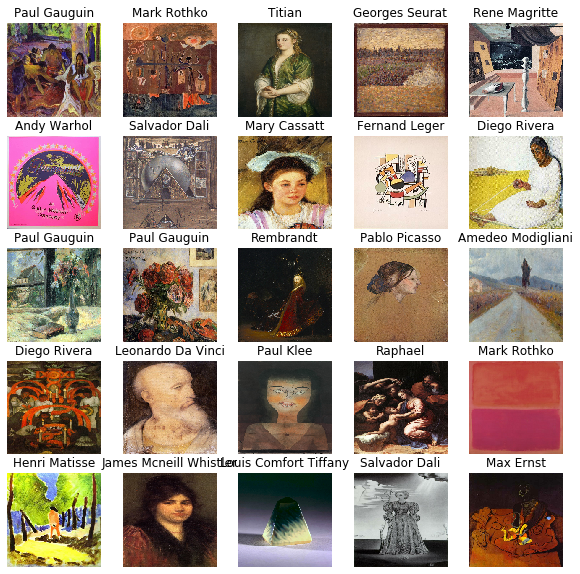

In [5]:
# Look at a batch
peek, peek_size = load_dataset('train', shuffle_buffer_size=32)
image_batch, label_batch = next(iter(peek))

def postprocess_image(image):
    image = image.numpy()
    image[:, :, 0] += 103.939
    image[:, :, 1] += 116.779
    image[:, :, 2] += 123.68
    out = np.clip(image[:, :, ::-1], 0, 255).astype('uint8')
    return tf.convert_to_tensor(out)

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(postprocess_image(image_batch[n]))
        plt.title(class_names[label_batch[n]==1][0].title())
        plt.axis('off')

show_batch(image_batch, label_batch.numpy())

## Build Classifier

### Setup
Helper functions to set tracking callbacks with different logs for each model, define metrics, and some helper functions to view logs and load the most recent saved model

In [6]:
# Helper Function to set callbacks based on model_name
def get_callbacks(model_name, early_stop = 3):
    callbacks = [
        CSVLogger(f'./logs/{model_name}-log.csv', append = True),
        ModelCheckpoint(filepath=f'./logs/models/{model_name}'+'-{epoch:02d}-{val_loss:.2f}.hdf5'),
        TerminateOnNaN()
    ]
    if early_stop:
        callbacks.append(EarlyStopping(patience = early_stop, restore_best_weights = False))
    return callbacks

# Metrics to track
metrics   = [
    CategoricalAccuracy(name = 'accuracy'),
    TopKCategoricalAccuracy(3, name = 'top-3-accuracy'),
    TopKCategoricalAccuracy(5, name = 'top-5-accuracy'),
]

# Helper Function to get fitting history
def get_fitting_history(model_name):
    log_file_name = f'./logs/{model_name}-log.csv'
    hist = pd.read_csv(log_file_name)
    hist       = pd.read_csv(log_file_name)
    max_epoch  = hist.epoch.max()
    best_epoch = hist.set_index('epoch').val_loss.idxmax()
    if len(hist.epoch) != len(hist.epoch.unique()):
        print('Warning: some epochs were fit multiple times')
    return max_epoch, best_epoch, hist

# Helper functions to get most recently saved model
model_dir = './logs/models/'
def get_saved_models(model_name):
    fnames = os.listdir(model_dir)
    model_epochs = {}
    
    # Look for models stored by epoch
    for fname in fnames:
        re_ = re.match(f'{model_name}-(\d+)', fname)
        if re_:
            epoch = int(re_.group(1))
            if epoch in model_epochs:
                print(f'Warning, multiple models for {model_name}-{epoch}. '
                      f'Ignoring {model_epochs[epoch]} in favor of {fname}')
            model_epochs[epoch] = fname
            
    # If none are found, look for models stored without epoch information
    if len(model_epochs) == 0:
        for fname in fnames:
            if fname == model_name + '.hdf5':
                return {-1 : fname}
    
    return model_epochs

def clear_saved_models(model_name):
    model_dict = get_saved_models(model_name)
    for model in model_dict.values():
        os.remove(model_dir + model)

def get_most_recent_saved_model(model_name, model = None, remove_old = False):
    model_epochs = get_saved_models(model_name)
    if len(model_epochs) == 0:
        print(f'No previous models found')
        return model, 0
    else:
        max_epoch = max(model_epochs.keys())
        print(f'Most recent: epoch {max_epoch} found in {model_epochs[max_epoch]} being loaded')
        max_model = load_model('./logs/models/' + model_epochs[max_epoch])
        out = (max_model, max_epoch)
    
        # Possibly remove old models to conserve memory
        if remove_old:
            for epoch in model_epochs:
                if epoch < max_epoch:
                    print(f'Removing old model {model_epochs[epoch]}')
                    os.remove(model_dir + model_epochs[epoch])
        return out
    
def view_all_saved_models():
    root   = './logs/models/'
    fnames = os.listdir(root)
    df = []
    for fname in fnames:
        df.append({'file' : fname,
                   'size_mb' : os.path.getsize(root+fname)/1000000})
    df = pd.DataFrame.from_records(df)
    print(f'Total of {df.size_mb.sum()} MB of stored models on disk')
    return df

def freeze_model(model_name, best_epoch):
    saved_models = get_saved_models(model_name)
    if -1 in saved_models:
        print(f'Model appears to already be frozen; terminating')
        return
    best_model   = saved_models[best_epoch]
    
    # Rename the best one
    os.rename(model_dir + best_model, model_dir + model_name + '.hdf5')
    for epoch, model in saved_models.items():
        if epoch != best_epoch:
            os.remove(model_dir + model)

### Attempt 1
The original DeepDream was built using [GoogLeNet](https://arxiv.org/abs/1409.4842) which won the ILSVRC (ImageNet Large Scale Visual Recognition Competition) in [2014](http://image-net.org/challenges/LSVRC/2014/).

In the spirit of keeping things simple, a first attempt will be made using a VGGNet (from the [Visual Geometry Group at Oxford](https://www.robots.ox.ac.uk/~vgg/)). This placed 2nd in ILSVRC 2014 but is substantially simpler in architecture, being essentially a vanilla convolutional net.

We don't want to use the pre-existing weights, so we will attempt to train from scratch. You can see the model on the tensorflow [github](https://github.com/tensorflow/tensorflow/blob/23c3bdaacdc27bb82dfd1772efefad687508923a/tensorflow/python/keras/applications/vgg19.py). Note that it is not precisely the same as described in the paper

In [ ]:
# Load Data
train, train_size       = load_dataset('train')
validate, validate_size = load_dataset('validate', shuffle=False)

# Load a blank VGG-19
model_name = 'vgg19'
model = VGG19(include_top = True, weights = None, input_shape = (width, height, 3), classes = len(class_names))
print(model.summary());

# Compile the model
optimizer = Adam()
model.compile(optimizer, 
              loss = CategoricalCrossentropy(),
              metrics = metrics)

# Find the most recent epoch run
model, next_epoch = get_most_recent_saved_model(model_name, model, remove_old=True)

history = model.fit(
    train,
    validation_data  = validate,
    epochs           = 30,
    verbose          = 1,
    callbacks        = get_callbacks(model_name),
    validation_steps = validate_size // batch_size + 1,
    steps_per_epoch  = train_size    // batch_size + 1,
    initial_epoch    = next_epoch
)

### Attempt 2b
Training from scratch was a bit of a tall order. Let's start with transfer learning.

This started to overfit after the 8th Epoch, so is frozen to that.

In [ ]:
# Let's try a smaller batch size
batch_size = 32

# Load Data
train, train_size       = load_dataset('train', batch_size = batch_size)
validate, validate_size = load_dataset('validate', shuffle=False, batch_size = batch_size)

In [ ]:
# Load Data
train, train_size       = load_dataset('train', batch_size = batch_size)
validate, validate_size = load_dataset('validate', shuffle=False, batch_size = batch_size)

# Load a pre-trained VGG-19
model_name = 'vgg19-INet-top-b'
model = VGG19(include_top = False, weights = 'imagenet', input_shape = (width, height, 3))
model = Sequential(model.layers, name = 'vgg19-INet')

# Freeze the pre-trained layers
for layer in model.layers:
    layer.trainable = False

# Add new top layers in the same format
model.add(Flatten())
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation = 'softmax'))

# Compile the model
optimizer = Adam()
model.compile(optimizer, 
              loss = CategoricalCrossentropy(),
              metrics = metrics)
print(model.summary())

# Find the most recent epoch run
model, next_epoch = get_most_recent_saved_model(model_name, model, remove_old = True)

# Don't fit if a best model has been set
if next_epoch != -1:
    history = model.fit(
        train,
        validation_data  = validate,
        epochs           = 30,
        verbose          = 1,
        callbacks        = get_callbacks(model_name),
        validation_steps = validate_size // batch_size + 1,
        steps_per_epoch  = train_size    // batch_size + 1,
        initial_epoch    = next_epoch
    )

In [ ]:
freeze_model('vgg19-INet-top-b', best_epoch = 8)

In [ ]:
batch_size = 32

# Load the previous model trained on the top layers
model_name = 'vgg19-INet-down1-b'
model, _ = get_most_recent_saved_model('vgg19-INet-top-b')
model = Sequential(model.layers, name = model_name)

for layer in model.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True

# Compile the model,
#  Lower the learning rate to avoid wrecking pre-learned weights
optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer, 
              loss = CategoricalCrossentropy(),
              metrics = metrics)

# Find the most recent epoch run
model, next_epoch = get_most_recent_saved_model(model_name, model, remove_old = False)

if next_epoch != -1:
    history = model.fit(
        train,
        validation_data  = validate,
        epochs           = 30,
        verbose          = 1,
        callbacks        = get_callbacks(model_name),
        validation_steps = validate_size // batch_size + 1,
        steps_per_epoch  = train_size    // batch_size + 1,
        initial_epoch    = next_epoch
    )

In [ ]:
freeze_model('vgg19-INet-down1-b', best_epoch=5)

In [ ]:
batch_size = 32

# Load the previous model trained on the top layers
model_name = 'vgg19-INet-down2-b'
model, _ = get_most_recent_saved_model('vgg19-INet-down1-b')

for layer in model.layers:
    if layer.name.startswith('block4'):
        layer.trainable = True

# Compile the model
optimizer = Adam(learning_rate = 0.00001)
model.compile(optimizer, 
              loss = CategoricalCrossentropy(),
              metrics = metrics)

# Find the most recent epoch run
model, next_epoch = get_most_recent_saved_model(model_name, model, remove_old = False)

if next_epoch != -1:
    history = model.fit(
        train,
        validation_data  = validate,
        epochs           = 30,
        verbose          = 1,
        callbacks        = get_callbacks(model_name),
        validation_steps = validate_size // batch_size + 1,
        steps_per_epoch  = train_size    // batch_size + 1,
        initial_epoch    = next_epoch
    )

In [ ]:
freeze_model('vgg19-INet-down2-b', best_epoch=2)

In [ ]:
batch_size = 32

# Load the previous model trained on the top layers
model_name = 'vgg19-INet-down3-b'
model, _ = get_most_recent_saved_model('vgg19-INet-down2-b')

for layer in model.layers:
    if layer.name.startswith('block3'):
        layer.trainable = True

# Compile the model
optimizer = Adam(learning_rate = 0.000001)
model.compile(optimizer, 
              loss = CategoricalCrossentropy(),
              metrics = metrics)

# Find the most recent epoch run
model, next_epoch = get_most_recent_saved_model(model_name, model, remove_old = False)

if next_epoch != -1:
    history = model.fit(
        train,
        validation_data  = validate,
        epochs           = 30,
        verbose          = 1,
        callbacks        = get_callbacks(model_name),
        validation_steps = validate_size // batch_size + 1,
        steps_per_epoch  = train_size    // batch_size + 1,
        initial_epoch    = next_epoch
    )

In [ ]:
clear_saved_models('vgg19-INet-down3-b')

In [ ]:
batch_size = 32

# Load the previous model trained on the top layers
model_name = 'vgg19-INet-down4-b'
model, _ = get_most_recent_saved_model('vgg19-INet-down3-b')

for layer in model.layers:
    if layer.name.startswith('block2'):
        layer.trainable = True

# Compile the model
optimizer = Adam(learning_rate = 0.0000001)
model.compile(optimizer, 
              loss = CategoricalCrossentropy(),
              metrics = metrics)

# Find the most recent epoch run
model, next_epoch = get_most_recent_saved_model(model_name, model, remove_old = False)

if next_epoch != -1:
    history = model.fit(
        train,
        validation_data  = validate,
        epochs           = 30,
        verbose          = 1,
        callbacks        = get_callbacks(model_name),
        validation_steps = validate_size // batch_size + 1,
        steps_per_epoch  = train_size    // batch_size + 1,
        initial_epoch    = next_epoch
    )

In [ ]:
batch_size = 32
model, _ = get_most_recent_saved_model('vgg19-INet-down2-b')
test, test_size = load_dataset('test', batch_size = batch_size, shuffle = False, repeat=True, cache = True)
model.evaluate(test, steps = test_size // batch_size + 1)

### Attempt 3
With feature extraction via a Neural Algorithm of Artistic Style

In [21]:
# Settings
batch_size = 32
width = height = 224
dropout_rate = 0.2

In [13]:
# Load Data
train, train_size       = load_dataset('train', width = width, height = height, batch_size = batch_size)
validate, validate_size = load_dataset('validate', shuffle=False, width = width, height = height, batch_size = batch_size)

In [14]:
# Clean out any clutter
tf.keras.backend.clear_session()

In [15]:
# Load a blank VGG-19
model_name = 'vgg19-style'
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (width, height, 3))

In [22]:
# Build a model with feature extraction
style_layers = ['block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

input_  = Input(shape=(width, height, 3), name='input')
current = input_
signals = []
for layer in base_model.layers[1:]:
    layer.trainable = False
    if layer.name in style_layers:
        signals.append(Lambda(gram_matrix)(current))
    current = layer(current)
signals.append(current)

# Flatten each signal and feed into a dense network with 1024 nodes (dropout)
signals = [Flatten(name = f'flatten_{i}')(signal) for i, signal in enumerate(signals)]
signals = [Dense(1024, activation='relu', name = f'downsample_{i}')(signal) for i, signal in enumerate(signals)]
signals = [Dropout(dropout_rateout_rate, name = f'dropout_{i}')(signal) for i, signal in enumerate(signals)]

# Concatenate the inputs and feed them into two 4096 dense layers with dropout
signal  = Concatenate(name = 'concatenate')(signals)
signal  = Dense(4096, name = 'fc1', activation = 'relu')(signal)
signal  = Dropout(dropout_rate, name = f'dropout_fc1')(signal)
signal  = Dense(4096, name = 'fc2', activation = 'relu')(signal)
signal  = Dropout(dropout_rate, name = f'dropout_fc2')(signal)

# Final output layer
signal  = Dense(53, name = 'output', activation = 'softmax')(signal)

model = Model(inputs = input_, outputs = signal)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[2][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[2][0]               
____________________________________________________________________________________________

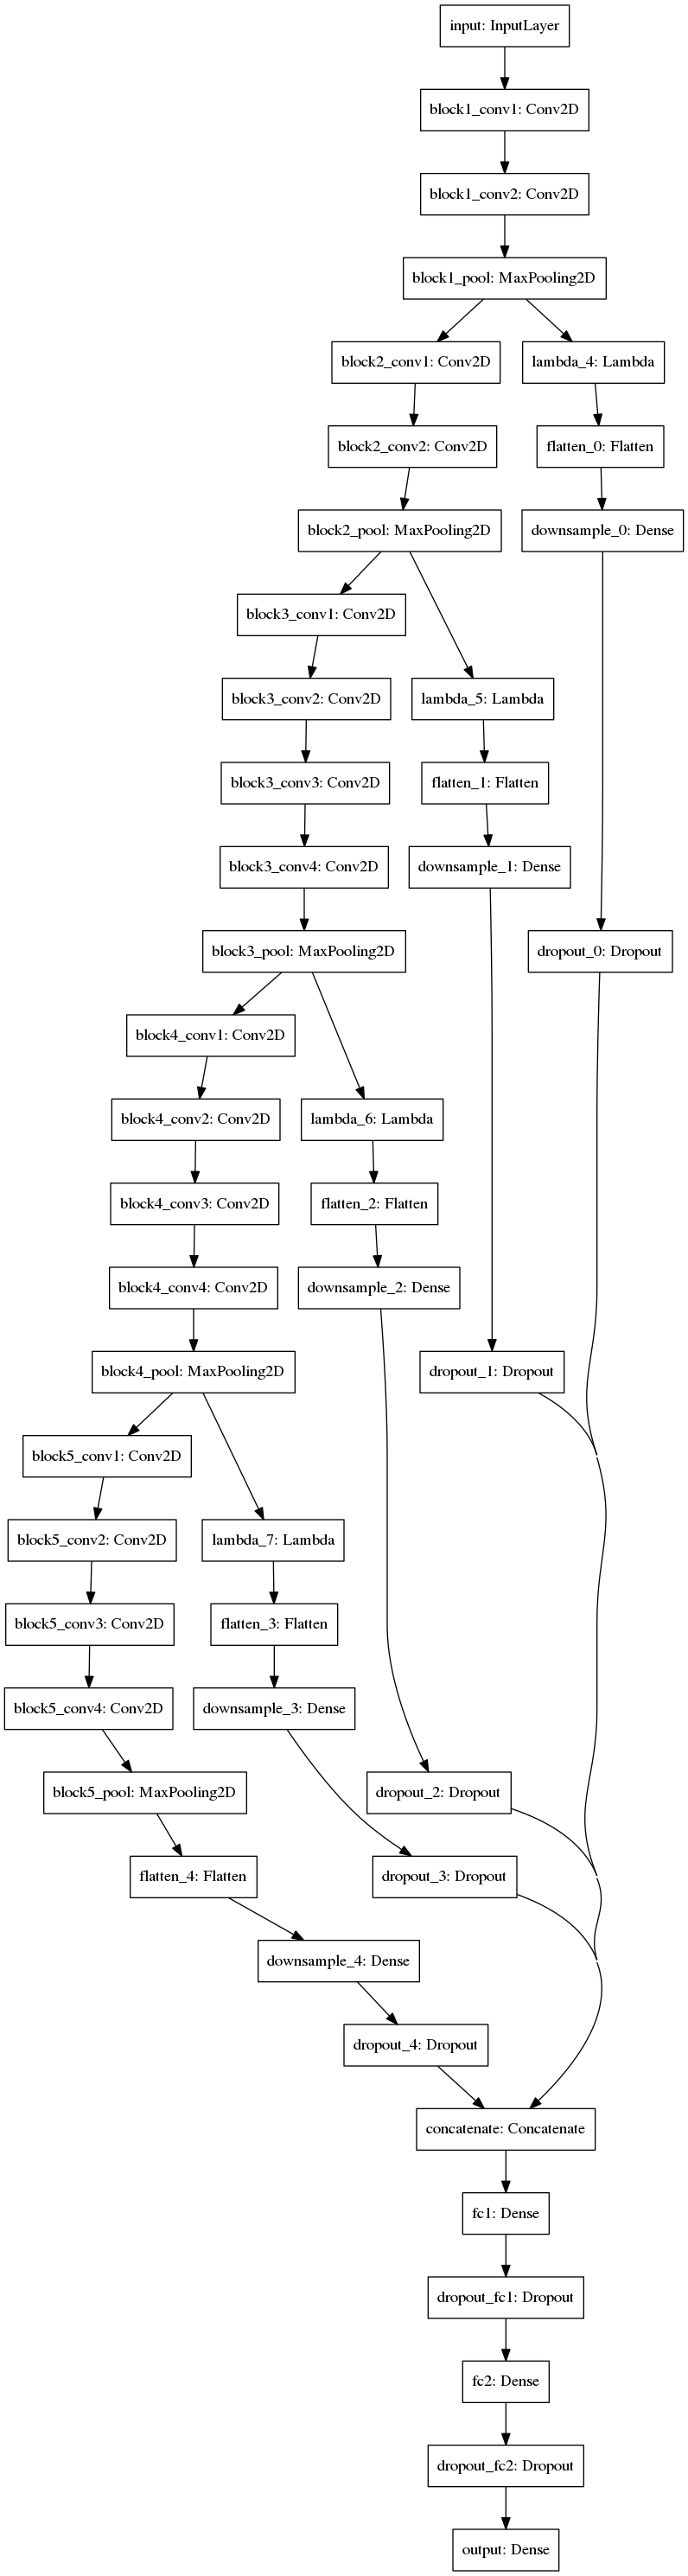

In [23]:
plot_model(model)

In [24]:
# Compile the model
optimizer = Adam()
model.compile(optimizer, 
              loss = CategoricalCrossentropy(),
              metrics = metrics)

In [ ]:
# Find the most recent epoch run
# model, next_epoch = get_most_recent_saved_model(model_name, model, remove_old=True)
next_epoch = 0

history = model.fit(
    train,
    validation_data  = validate,
    epochs           = 30,
    verbose          = 1,
    callbacks        = get_callbacks(model_name, early_stop = 10),
    validation_steps = validate_size // batch_size + 1,
    steps_per_epoch  = train_size    // batch_size + 1,
    initial_epoch    = next_epoch
)

In [ ]:
# # i = 3
# # signal = signals[i]
# # signal = Dense(2048, activation = 'relu')(signal)
# # signal = Dense(2048, activation = 'relu')(signal)
# # aux_output = Dense(53, name = f'dummy_{i}', activation = 'softmax')(signal)
# # model = Model(inputs = input_, outputs = aux_output)

# # Compile the model
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer, 
#               loss = CategoricalCrossentropy(),
#               metrics = metrics)

# # Find the most recent epoch run
# # model, next_epoch = get_most_recent_saved_model(model_name, model, remove_old=True)
# next_epoch = 0

# history = model.fit(
#     train,
#     validation_data  = validate,
#     epochs           = 30,
#     verbose          = 1,
#     callbacks        = [EarlyStopping(patience = 3)],
#     validation_steps = validate_size // batch_size + 1,
#     steps_per_epoch  = train_size    // batch_size + 1,
#     initial_epoch    = next_epoch
# )

# plot_model(model)